In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import corner
import matplotlib as mpl
import struct
%matplotlib inline

In [2]:
def read_CIC_scalar(filename):
    f = open(filename, "rb")
    dumb = f.read(38)

    dumb = f.read(4)
    n_x = f.read(4)
    n_y = f.read(4)
    n_z = f.read(4)
    nodes = f.read(8)
    x0 = f.read(4)
    y0 = f.read(4)
    z0 = f.read(4)
    dx = f.read(4)
    dy = f.read(4)
    dz = f.read(4)
    dumb = f.read(4)

    n_x = (struct.unpack('i', n_x))[0]
    n_y = (struct.unpack('i', n_y))[0]
    n_z = (struct.unpack('i', n_z))[0]
    nodes = (struct.unpack('q', nodes))[0]
    dx = (struct.unpack('f', dx))[0]
    dy = (struct.unpack('f', dy))[0]
    dz = (struct.unpack('f', dz))[0]
    x0 = (struct.unpack('f', x0))[0]
    y0 = (struct.unpack('f', y0))[0]
    z0 = (struct.unpack('f', z0))[0]
    print n_x, n_y, n_z, nodes, dx, dy, dz

    total_nodes = n_x * n_y *n_z
    dumb = f.read(4)
    array_data = f.read(total_nodes*4)
    dumb = f.read(4)
    format_s = str(total_nodes)+'f'
    array_data = struct.unpack(format_s, array_data)
    f.close()
    array_data  = np.array(array_data)
    array_data.resize(n_z,n_y,n_x)
    array_data = array_data.transpose()
    return {'eigenval':array_data, 'delta_x':dx}


In [3]:
def read_vector_ascii(filename, boxsize=75000.0):
    data = np.loadtxt(filename)
    ii = data[:,0]
    n_side = len(set(ii))
    print(n_side)
    delta_size = boxsize/n_side
    new_data = np.ones((3,n_side, n_side, n_side))
    n = 0 
    for i in range(n_side):
        for j in range(n_side):
            for k in range(n_side):
                new_data[:,i,j,k] = data[n,3:]
                n= n+1
    return {'eigenvec':new_data, 'delta_x':delta_size}

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot. 
    Source code: Adrian Price-Whelan https://gist.github.com/adrn/3993992
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 1.0 - np.exp(-0.5)))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 1.0 - np.exp(-2.0)))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 1.0 - np.exp(-4.5)))
    levels = [one_sigma, two_sigma, three_sigma]

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)

    return contour

In [5]:
def set_ticklabels(ax, size=18):
    ticklabels_x = ax.get_xticklabels()
    ticklabels_y = ax.get_yticklabels()

    for label_x in ticklabels_x:
        label_x.set_fontsize(size)
        label_x.set_family('serif')
    for label_y in ticklabels_y:
        label_y.set_fontsize(size)
        label_y.set_family('serif')

In [6]:
def main_halos(snap_data):
    sorted_vmax = snap_data['vmax']
    sorted_vmax = np.sort(sorted_vmax)
    v_max_A = sorted_vmax[-1]
    v_max_B = sorted_vmax[-2]
    v_max_C = sorted_vmax[-3]
    ii = snap_data['vmax']==v_max_A
    jj = snap_data['vmax']==v_max_B
    #kk = snap_data['vmax']==v_max_C
    index = (ii | jj)
    #print sorted_vmax[-3::]
    main_halos_data = snap_data[index]
    if(main_halos_data['vmax'][0] < main_halos_data['vmax'][1]):
        tmp = main_halos_data[0].copy()
        main_halos_data[0] = main_halos_data[1].copy()
        main_halos_data[1] = tmp.copy()
    return main_halos_data

In [7]:
def satellite_halos(halo_data, halo_center):
    tmp_halo = halo_data.copy()
    radius = halo_center['vmax']/(10.0 * 100) * 1000 # in kpc/h
    for col in list(['x','y','z']):
        tmp_halo[col] = tmp_halo[col] - halo_center[col]
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    ii = r < radius
    return halo_data[ii]

In [8]:
def load_snapshot(snap_name, boxsize=75000.0):
    dtype=[('subid','i8'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('vx', 'f8'),
           ('vy', 'f8'),
           ('vz', 'f8'),
           ('vmax', 'f8'),
           ('bmag', 'f8')]
    snap_data = np.loadtxt(snap_name, dtype=dtype)    
    # this takes into account periodic boudary conditions
    for col in list(['x','y','z']):
        if((snap_data[col].max() - snap_data[col].min()) > 0.5 * boxsize):
            snap_data[col] = (snap_data[col] - 0.5 * boxsize) % boxsize
        
    return snap_data

In [9]:
def load_obs(obs_name):
    dtype=[('name','|S20'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('delta_plus', 'f8'),
           ('delta_minus', 'f8'),
           ('bmag', 'f8'),
           ('delta_bmag', 'f8')]
    obs_data = np.loadtxt(obs_name, dtype=dtype)    
    return obs_data

In [29]:
def get_environment(eigenv_1, eigenv_2, eigenv_3, 
                    eigenvec_1, eigenvec_2, eigenvec_3, pos_x=0.0, pos_y=0.0, pos_z=0.0):
    delta_x = eigenv_1['delta_x']
    i = int(pos_x//delta_x)
    j = int(pos_y//delta_x)
    k = int(pos_z//delta_x)
    norma = np.sqrt(np.sum(eigenvec_3['eigenvec'][:,i,j,k]**2))
    e1 = eigenv_1['eigenval'][i,j,k]
    e2 = eigenv_2['eigenval'][i,j,k]
    e3 = eigenv_3['eigenval'][i,j,k]
    FA = ((e1-e3)**2 + (e2-e3)**2 + (e1-e2)**2)/(e1**2 + e2**2 + e3**2)
    FA = np.sqrt(FA/3.0)
    return {'eigen_1': eigenv_1['eigenval'][i,j,k],
                'eigen_2': eigenv_2['eigenval'][i,j,k],
                'eigen_3': eigenv_3['eigenval'][i,j,k],
                'eigenvec_3': eigenvec_3['eigenvec'][:,i,j,k]/norma, 
                'eigenvec_1': eigenvec_1['eigenvec'][:,i,j,k]/norma, 
               'FA': FA}

In [30]:
eigen_1 = read_CIC_scalar("../data/tweb/snap_135.s1.00.eigen_1")
eigen_2 = read_CIC_scalar("../data/tweb/snap_135.s1.00.eigen_2")
eigen_3 = read_CIC_scalar("../data/tweb/snap_135.s1.00.eigen_3")
eigenv_1 = read_vector_ascii("../data/tweb/snap_135.s1.00.eigenvec_1.dat")
eigenv_2 = read_vector_ascii("../data/tweb/snap_135.s1.00.eigenvec_2.dat")
eigenv_3 = read_vector_ascii("../data/tweb/snap_135.s1.00.eigenvec_3.dat")


FA = (eigen_1['eigenval']-eigen_3['eigenval'])**2  + (eigen_2['eigenval']-eigen_3['eigenval'])**2\
    + (eigen_1['eigenval']-eigen_2['eigenval'])**2 
FA = FA/(eigen_1['eigenval']**2 + eigen_2['eigenval']**2 + eigen_3['eigenval']**2)
FA = np.sqrt(FA)/np.sqrt(3.0)

76 76 76 438976 986.842102051 986.842102051 986.842102051
76 76 76 438976 986.842102051 986.842102051 986.842102051
76 76 76 438976 986.842102051 986.842102051 986.842102051
76
76
76


In [31]:
def get_beta(center, sat_pos, sat_vel):
    beta = 0.0
    center_sat_pos = np.zeros(3)
    center_sat_vel = np.zeros(3)
    #print 'center', center
    n = len(sat_pos)
    #print 'satellites', n
    
    sum_perp = 0.0
    sum_parallel = 0.0
    for i in range(n):
        #print 'center sat pos', sat_pos[i]
        center_sat_pos[0] = sat_pos['x'][i] - center['x']
        center_sat_pos[1] = sat_pos['y'][i] - center['y']
        center_sat_pos[2] = sat_pos['z'][i] - center['z']
        center_sat_vel[0] = sat_vel['vx'][i] - center['vx'] 
        center_sat_vel[1] = sat_vel['vy'][i] - center['vy']
        center_sat_vel[2] = sat_vel['vz'][i] - center['vz']
        
        norm_pos = np.sqrt(np.sum(center_sat_pos * center_sat_pos))
        norm_vel = np.sqrt(np.sum(center_sat_vel * center_sat_vel))
        #print 'norm pos vel', norm_pos, norm_vel
        if (norm_pos>0 and norm_vel >1.0):
            p_vel = (np.sum(center_sat_pos*center_sat_vel)/norm_pos)
            sum_parallel += p_vel**2.0
            sum_perp += norm_vel**2.0 - p_vel**2.0
            
            #print 'parallel, perp', parallel_vel, perp_vel
           
    beta = 1.0 - sum_perp/(2.0*sum_parallel)
    return beta

In [32]:
n_pairs = 53
beta_A = np.ones(n_pairs)
beta_B = np.ones(n_pairs)
n_bright_A = np.ones(n_pairs)
n_bright_B = np.ones(n_pairs)
FA_A = np.ones(n_pairs)
FA_B = np.ones(n_pairs)

for i in range(n_pairs):
    filename = "../data/dm_selected/Illustris_group_{}.dat".format(i)
    data = load_snapshot(filename)
    main_h_data = main_halos(data)
    
    satellite_data_A = satellite_halos(data, main_h_data[0])
    satellite_data_B = satellite_halos(data, main_h_data[1])
    #print '==='
    i_A = satellite_data_A['bmag'] < -8.0
    i_B = satellite_data_B['bmag'] < -8.0

    n_bright_A[i] = np.count_nonzero(i_A)
    n_bright_B[i] = np.count_nonzero(i_B)
    #print len(satellite_data_B[i_B])
    #print len(satellite_data_B)
    beta_A[i] = get_beta(main_h_data[0], 
                        satellite_data_A[['x','y','z']][i_A],
                        satellite_data_A[['vx','vy','vz']][i_A])
    beta_B[i] = get_beta(main_h_data[1], 
                        satellite_data_B[['x','y','z']][i_B],
                        satellite_data_B[['vx','vy','vz']][i_B])
    env_A = get_environment(eigen_1, eigen_2, eigen_3, 
                            eigenv_1, eigenv_2, eigenv_3, 
                            pos_x=main_h_data[0]['x'], 
                            pos_y=main_h_data[0]['y'], 
                            pos_z=main_h_data[0]['z'])
    env_B = get_environment(eigen_1, eigen_2, eigen_3, 
                            eigenv_1, eigenv_2, eigenv_3, 
                            pos_x=main_h_data[1]['x'], 
                            pos_y=main_h_data[1]['y'], 
                            pos_z=main_h_data[1]['z'])
    FA_A[i] = env_A['FA']
    FA_B[i] = env_B['FA']

2 39


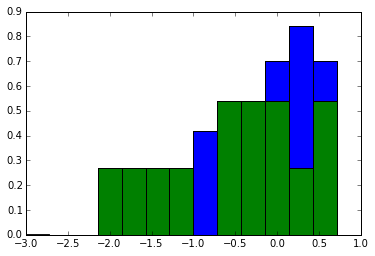

In [57]:
#plt.scatter(beta_A, beta_B)
beta = beta_A.copy()
beta = np.append(beta, beta_B)

n_bright = n_bright_A.copy()
n_bright = np.append(n_bright, n_bright_B)

fa = FA_A.copy()
fa = np.append(fa, FA_B)
ii = beta< -2.0
print np.count_nonzero(ii[n_bright>9]), len(beta[n_bright>9])
a = plt.hist(beta_A[n_bright_A>9], bins=np.linspace(-3.0,1.0,15), normed=True)
a = plt.hist(beta_B[n_bright_B>9], bins=np.linspace(-3.0,1.0,15), normed=True)
#a = plt.hist(beta[n_bright>9], bins=np.linspace(-3.0,1.0,30), normed=True)

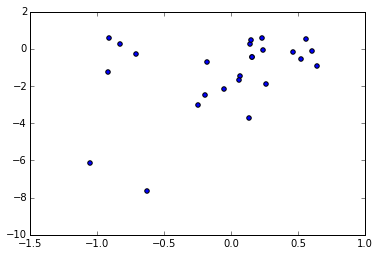

In [58]:
plt.scatter(beta_A[n_bright_A>9], beta_B[n_bright_A>9])

(-8, 1)

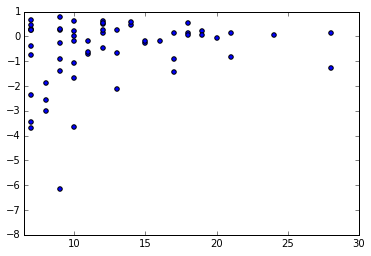

In [59]:
plt.scatter(n_bright_A, beta_A)
plt.scatter(n_bright_B, beta_B)
plt.xlim([6.5,30])
plt.ylim([-8,1])

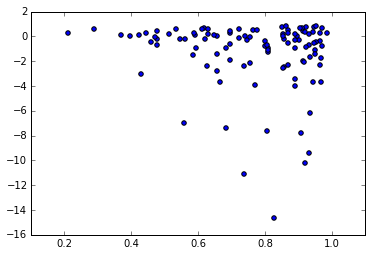

In [60]:
plt.scatter(fa, beta)

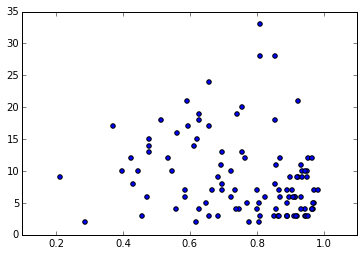

In [61]:
plt.scatter(fa, n_bright)

In [62]:
n = len(fa)
f = open('summary.dat', 'w')
for i in range(n):
    f.write('{} {} {}\n'.format(fa[i], n_bright[i], beta[i]))
f.close()

In [87]:
ii = np.where(beta < -2.2)
ii = ii[0]
jj = np.where(beta >= -2.2)
jj = jj[0]
n_good = len(ii)
print n_good, len(fa[ii])
n_bad = len(jj)
n_all = len(beta)
int_good = np.linspace(1.0/n_good, 1.0, n_good)
int_bad = np.linspace(1.0/n_bad, 1.0, n_bad)
int_all = np.linspace(1.0/n_all, 1.0, n_all)
fa_good = fa[ii]

23 23


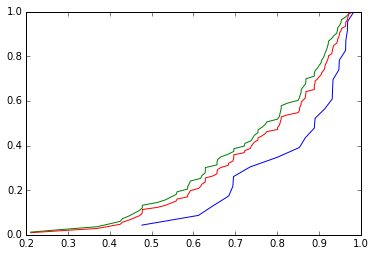

In [88]:
plt.plot(np.sort(fa[ii]), int_good)
plt.plot(np.sort(fa[jj]), int_bad)
plt.plot(np.sort(fa), int_all)

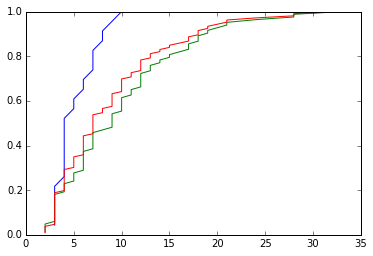

In [89]:
plt.plot(np.sort(n_bright[ii]), int_good)
plt.plot(np.sort(n_bright[jj]), int_bad)
plt.plot(np.sort(n_bright), int_all)